In [1]:
from qiskit.transpiler.coupling import CouplingMap

from src.clonk.backend_utils.mock_backends.Corral_backend_v1 import FakeCorral
import numpy as np


def pretty_print(edge_list, simple=True):
    if simple:
        temp = list(edge_list)
        temp2 = []
        for i, j in temp:
            if not (j, i) in temp2:
                temp2.append((i, j))
        edge_list = temp2

    x = CouplingMap(edge_list)

    # black magic errors when I modify the draw function directly in the CouplingMap file so Im just copying the code here to make it work
    import pydot
    from PIL import Image
    import io

    formatter2 = lambda _: dict(dir="none")
    dot_str = x.graph.to_dot(edge_attr=formatter2, graph_attr={"size": "0"})
    dot = pydot.graph_from_dot_data(dot_str)[0]
    png = dot.create_png(prog="sfdp")
    pdf = dot.create_pdf(prog="sfdp")
    # png = dot.create_png(prog="neato")
    return Image.open(io.BytesIO(png))

In [2]:
# define corral
def corral(num_snails=32, num_levels=2):
    """returns edge list of a corral of size specified
    snails are nodes, edges are qubits"""

    snail_edge_list = []
    for snail0, snail1 in zip(range(num_snails), range(1, num_snails + 1)):
        for i in range(num_levels):
            snail_edge_list.append((snail0, snail1 % num_snails))
    return snail_edge_list

In [3]:
def snail_to_connectivity(snail_edge_list):
    # Convert snail edge list where nodes are snails and edges are qubits
    # To connectivity edge list where nodes are qubits and edges are coupling
    edge_list = []

    # qubits are coupled to a snail edge if they are both adjacent to a snail node
    for qubit, snail_edge in enumerate(snail_edge_list):
        for temp_qubit, temp_snail_edge in enumerate(snail_edge_list):
            if qubit != temp_qubit and (
                snail_edge[0] in temp_snail_edge or snail_edge[1] in temp_snail_edge
            ):
                edge_list.append((qubit, temp_qubit))
    return edge_list

In [4]:
def get_max_from_tupleList(tuptup):
    x = max(tuptup, key=lambda item:item[1])[1] #find max looking at second item
    y = max(tuptup)[0] #find max looking at first item

    return max(x,y) #return max item of all tuple pairs

In [5]:
#check that corrals don't overlap with node names
#assume corrals start at 0 increase sequentially
def updateCorralNodeNames(c1,c2):
    c1_offset = get_max_from_tupleList(c1) + 1 #increment by one to get offset
    c2_offset = get_max_from_tupleList(c2) + 1
    new1, new2 = [], []
    if c2_offset < c1_offset: #offset c2 by c1_max
        new1 = c1
        for e in c2:
            first = e[0] + c1_offset
            second = e[1] + c1_offset
            new2.append((first,second))
    else:
        new2 = c2
        for e in c1:
            first = e[0] + c2_offset
            second = e[1] + c2_offset
            new1.append((first,second))
    return new1, new2

In [6]:
#function to combine two corrals
#take in two corrals
#find two nodes on each that are directly connected
#add edge to opposite and diagonal nodes in between corrals
#remove edge connecting nodes in each corral
#remove edge for each node -> connect the nodes that were connected to removed edge

#TODO param to adjust how many nodes in between connected?
def connect_corrals(cor_1, cor_2):
    cor_1, cor_2 = updateCorralNodeNames(cor_1, cor_2) #update corral node numbers so no overlap between the two corrals with names
    cor1_n1 = cor_1[0][0] #get first node of first tuple
    cor1_n2 = cor_1[0][1] #get second node of tuple to connect with other corral
    cor2_n1 = cor_2[0][0] 
    cor2_n2 = cor_2[0][1] 

    newEdges = []
    newEdges.append((cor1_n1, cor2_n1))
    newEdges.append((cor1_n1, cor2_n2))
    newEdges.append((cor1_n2, cor2_n1))
    newEdges.append((cor1_n2,cor2_n2))
    
    removeEdges = []
    cor_1.remove((cor1_n1,cor1_n2)) #remove edges connecting nodes in same corral
    cor_2.remove((cor2_n1,cor2_n2))
    #remove another edge from each node
    for e in cor_1:
        if cor1_n1 == e[0]:
            n1_temp = e[1]
            remove1 = e
        elif cor1_n1 == e[1]:
            n1_temp = e[0]
            remove1 = e
        elif cor1_n2 == e[0]:
            n2_temp = e[1]
            remove2 = e
        elif cor1_n2 == e[1]:
            n2_temp = e[0]
            remove2 = e
    for e in cor_2:
        if cor2_n1 == e[0]:
            n3_temp = e[1]
            remove3 = e
        elif cor2_n1 == e[1]:
            n3_temp = e[0]
            remove3 = e
        elif cor2_n2 == e[0]:
            n4_temp = e[1]
            remove4 = e
        elif cor2_n2 == e[1]:
            n4_temp = e[0]
            remove4 = e

    cor_1.remove(remove1)
    cor_1.remove(remove2)
    cor_2.remove(remove3)
    cor_2.remove(remove4)
    newEdges.append((n1_temp,n2_temp))
    newEdges.append((n3_temp,n4_temp))
    
    combinedCorral = cor_1 + cor_2
    combinedCorral = np.append(combinedCorral, newEdges, axis=0)
    return combinedCorral


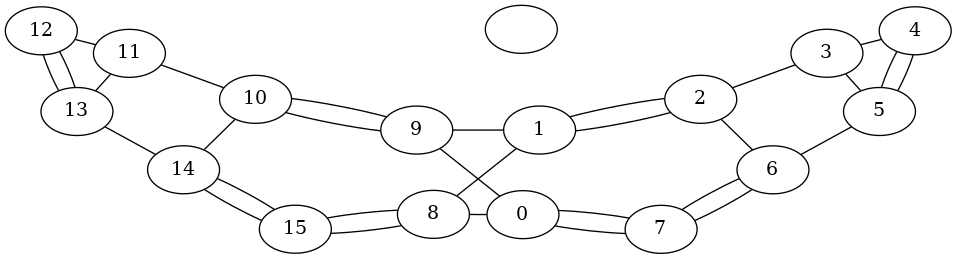

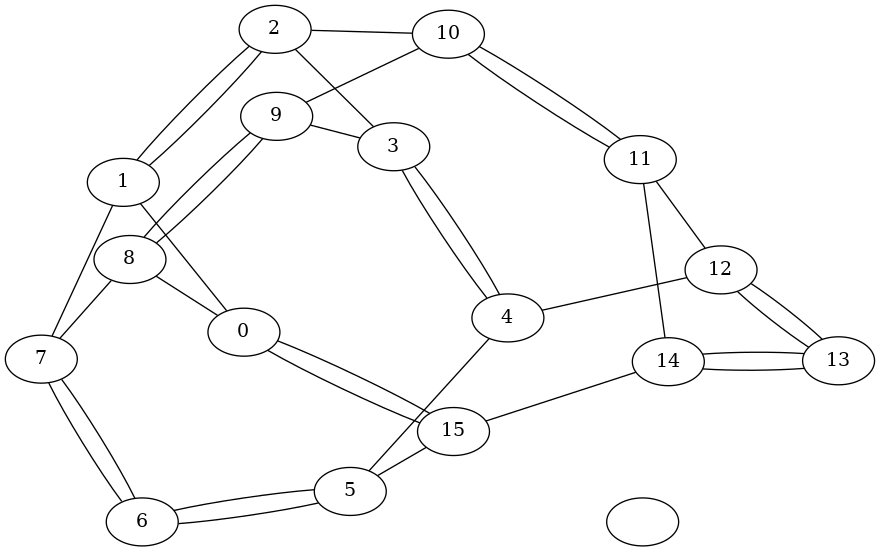

In [7]:
fc = FakeCorral()
c1 = corral(16//2,2)
c2 = corral(16//2,2)
c = corral(16,2)

c1 = list(fc.add_new_edges(c1, 4//2))
c2 = list(fc.add_new_edges(c2, 4//2))
n_16_0 = fc.connect_corrals(c1, c2)
c = list(fc.add_new_edges(c, 4))
# display(pretty_print(snail_to_connectivity( n_16_0)))
# display(pretty_print(snail_to_connectivity( c)))
display(pretty_print( n_16_0))
display(pretty_print(c))

# c1 = fc.add_new_edges(c1, 4)

# display(pretty_print(c1))
# display(pretty_print(c2))
# display(pretty_print(c))



In [8]:
#diff connection type,  way 2, 3 nodes
def connect_corrals_way2(cor_1, cor_2):
    cor_1, cor_2 = updateCorralNodeNames(cor_1, cor_2) #update corral node numbers so no overlap between the two corrals with names
    n0 = cor_1[0][0] #get first node of first tuple
    n1 = cor_1[0][1] #get second node of tuple to connect with other corral
    n2 = -1
    n3 = cor_2[0][0] 
    n4 = cor_2[0][1]
    n5 = -1
    outerN1 =-1 #nodes connected together at end after having edge removed
    outerN2 =-1 

    newEdges = []
    cor_1.remove((n0,n1)) #remove edges connecting nodes in same corral
    cor_2.remove((n3,n4))
    #find 3rd node, which is connected to either n1, or n2
    for e in cor_1:
        if n1 == e[0]:
            n2 = e[1]
            remove1 = e
        elif n1 == e[1]:
            n2 = e[0]
            remove1 = e
    for e in cor_2:
        if n4 == e[0]:
            n5 = e[1]
            remove2 = e
        elif n4 == e[1]:
            n5 = e[0]
            remove2 = e

    for e in cor_1:
        if n2 == e[0]:
            outerN1 = e[1]
            remove3 = e
        elif n2 == e[1]:
            outerN1 = e[0]
            remove3 = e
    for e in cor_2:
        if n5 == e[0]:
            outerN2 = e[1]
            remove4 = e
        elif n5 == e[1]:
            outerN2 = e[0]
            remove4 = e

    cor_1.remove(remove1) #remove edges connecting nodes in same corral 
    cor_1.remove(remove3)
    cor_2.remove(remove2)
    cor_2.remove(remove4)

    #connect 0-3,0-4 ; 1-4,1-5 ; 2-5, + nodes connected previously to n0 and n5 
    newEdges.append((n0,n3))
    newEdges.append((n0,n4))
    newEdges.append((n1,n4))
    newEdges.append((n1,n5))
    newEdges.append((n2,n5))
    newEdges.append((outerN1,outerN2))

    
    combinedCorral = cor_1 + cor_2
    combinedCorral = np.append(combinedCorral, newEdges, axis=0)
    return combinedCorral

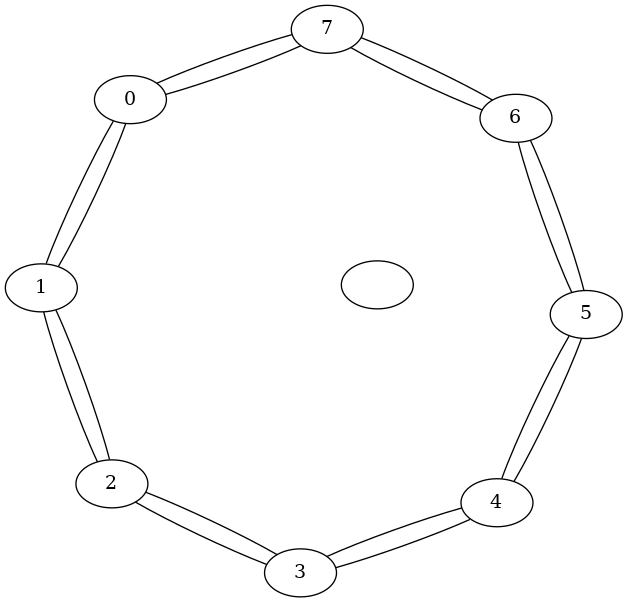

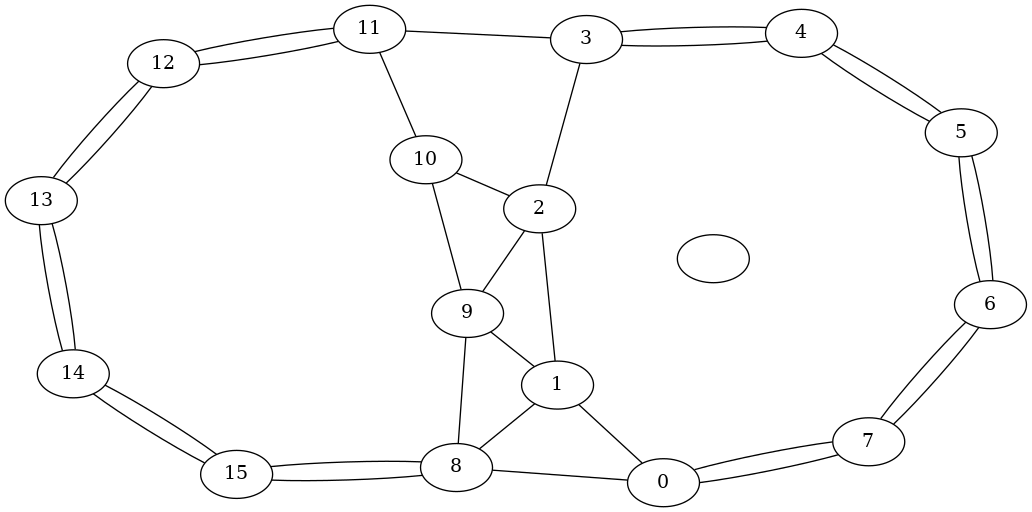

In [38]:
fc = FakeCorral()
c1 = corral(8,2)
c2 = corral(8,2)

display(pretty_print(c1))

combined = connect_corrals_way2(c1,c2)
display(pretty_print(combined))

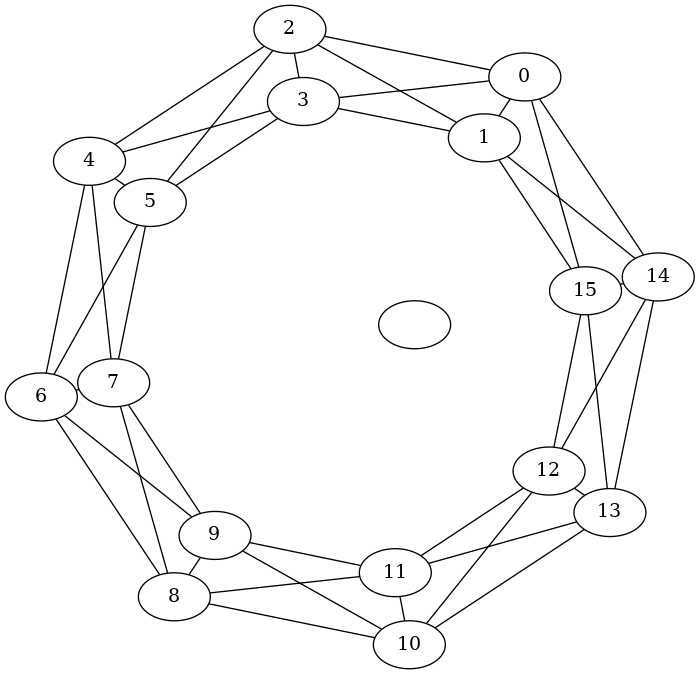

In [30]:
pretty_print(snail_to_connectivity( c1))

In [ ]:
c = FakeCorral()
basic_corral_16_2 = corral(16, 2)
basic_corral_16_2 = snail_to_connectivity(basic_corral_16_2)
display(pretty_print(basic_corral_16_2))

# check divideCorralK_math() w/ diff params
new_edges_16_2 = c.divideCorralK_math(basic_corral_16_2, 16, 2)
new_edges_32_2 = c.divideCorralK_math(basic_corral_16_2, 32, 2)
new_edges_16_4 = c.divideCorralK_math(basic_corral_16_2, 16, 4)
new_edges_32_4 = c.divideCorralK_math(basic_corral_16_2, 32, 4)

corral_16_2 = np.append(basic_corral_16_2, new_edges_16_2, axis=0)
corral_32_2 = np.append(basic_corral_16_2, new_edges_32_2, axis=0)
corral_16_4 = np.append(basic_corral_16_2, new_edges_16_4, axis=0)
corral_32_4 = np.append(basic_corral_16_2, new_edges_32_4, axis=0)

display(pretty_print(corral_32_2))
display(pretty_print(corral_16_2))
display(pretty_print(corral_32_4))
display(pretty_print(corral_16_4))

In [ ]:
c = FakeCorral()
basic_corral_32_2 = corral(32, 2)
basic_corral_32_2 = snail_to_connectivity(basic_corral_32_2)
display(pretty_print(basic_corral_32_2))
print(len(basic_corral_32_2))
new_edges_32_12 = c.divideCorralK_math(basic_corral_32_2, 32, 12)
new_edges_80_50 = c.divideCorralK_math(basic_corral_32_2, 80, 50)


corral_32_2 = np.append(basic_corral_32_2, new_edges_32_2, axis=0)
corral_80_50 = np.append(basic_corral_32_2, new_edges_80_50, axis=0)
print(basic_corral_32_2)
print(new_edges_32_2)

display(pretty_print(corral_32_2))
display(pretty_print(corral_80_50))

In [ ]:
c = FakeCorral()
basic_corral_32_2 = corral(32, 2)
basic_corral_32_2 = snail_to_connectivity(basic_corral_32_2)
display(pretty_print(basic_corral_32_2))
new_edges = c.divideCorralK_math(basic_corral_32_2, 80, 100)

corral_new = np.append(basic_corral_32_2, new_edges, axis=0)

display(pretty_print(corral_new))

In [ ]:
basic_corral_16_2 = corral(16, 2)
basic_corral_16_2 = snail_to_connectivity(basic_corral_16_2)
display(pretty_print(basic_corral_16_2))

# check divideCorralK_math() w/ diff params
new_edges_32_2 = c.divideCorralK_complete(basic_corral_16_2, 32, 2)
new_edges_32_32 = c.divideCorralK_complete(basic_corral_16_2, 32, 32)
new_edges_32_16 = c.divideCorralK_complete(basic_corral_16_2, 32, 16)
new_edges_32_8 = c.divideCorralK_complete(basic_corral_16_2, 32, 8)

corral_32_2 = np.append(basic_corral_16_2, new_edges_32_2, axis=0)
corral_32_32 = np.append(basic_corral_16_2, new_edges_32_32, axis=0)
corral_32_16 = np.append(basic_corral_16_2, new_edges_32_16, axis=0)
corral_32_8 = np.append(basic_corral_16_2, new_edges_32_8, axis=0)

display(pretty_print(corral_32_2))
display(pretty_print(corral_32_32))
display(pretty_print(corral_32_16))
display(pretty_print(corral_32_8))

In [ ]:
basic_corral_16_2 = corral(16, 2)
basic_corral_16_2 = snail_to_connectivity(basic_corral_16_2)
display(pretty_print(basic_corral_16_2))

# check divideCorralK_math() w/ diff params
new_edges_32_2 = c.divideCorralK_complete(basic_corral_16_2, 32, 200)
corral_32_2 = np.append(basic_corral_16_2, new_edges_32_2, axis=0)

display(pretty_print(corral_32_2))

In [10]:
# test benchmarking for diff amounto of qubits and different connectivities
from src.clonk.benchmark_suite.backend_suite_corral import simple_backends_v3

print([backend.label for backend in simple_backends_v3])

['Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3', 'Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3', 'Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3', 'Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3']


In [11]:
from src.clonk.benchmark_suite.circuit_suite import circuits

q_size = 4
circuits["QAOA_Vanilla"].circuit_lambda(q_size).decompose().draw()

┌─────────┐                                                           »
 q_0: ┤ U2(0,π) ├──■────────────────────────■───────────────────────────────»
      ├─────────┤  │                        │                               »
 q_1: ┤ U2(0,π) ├──┼────■───────────────────┼────■──────────────────────────»
      ├─────────┤┌─┴─┐  │  ┌─────────────┐┌─┴─┐  │                          »
 q_2: ┤ U2(0,π) ├┤ X ├──┼──┤ U1(-5.5611) ├┤ X ├──┼────■──────────────────■──»
      ├─────────┤└───┘┌─┴─┐└┬────────────┤└───┘┌─┴─┐┌─┴─┐┌────────────┐┌─┴─┐»
 q_3: ┤ U2(0,π) ├─────┤ X ├─┤ U1(5.5611) ├─────┤ X ├┤ X ├┤ U1(5.5611) ├┤ X ├»
      └─────────┘     └───┘ └────────────┘     └───┘└───┘└────────────┘└───┘»
m0: 4/══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                 »
« q_0: ──■──────────────────■─────────■────────────────────────■──»
«        │                  │       ┌─┴─┐     ┌─────────────┐┌─┴─┐»
« q_1: ──┼──────────────────┼───────┤ X ├─────┤ U1(-5.5611) ├┤ X ├»
«        │                  │       └───┘     └─────────────┘└───┘»
« q_2: ──┼──────────────────┼─────────────────────────────────────»
«      ┌─┴─┐┌────────────┐┌─┴─┐┌─────────────┐      ┌─┐           »
« q_3: ┤ X ├┤ U1(5.5611) ├┤ X ├┤ R(10.502,0) ├──────┤M├───────────»
«      └───┘└────────────┘└───┘└─────────────┘      └╥┘           »
«m0: 4/══════════════════════════════════════════════╩════════════»
«                                                    3            »
«      ┌─────────────┐               ┌─┐                          
« q_0: ┤ R(10.502,0) ├───────────────┤M├──────────────────────────
«      └─────────────┘               └╥┘     ┌─────────────┐┌─┐   
« q_1: ───────■───────────────────────╫───■──┤ R(10.502,0) ├┤M├───
«           ┌─┴─┐     ┌─────────────┐ ║ ┌─┴─┐├─────────────┤└╥┘┌─┐
« q_2: ─────┤ X ├─────┤ U1(-5.5611) ├─╫─┤ X ├┤ R(10.502,0) ├─╫─┤M├
«           └───┘     └─────────────┘ ║ └───┘└─────────────┘ ║ └╥┘
« q_3: ───────────────────────────────╫──────────────────────╫──╫─
«                                     ║                      ║  ║ 
«m0: 4/═══════════════════════════════╩══════════════════════╩══╩═
«                                     0                      1  2

This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Starting benchmark for Quantum_Volume
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3
Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Starting benchmark for QFT
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3
Starting benchmark for QAOA_Vanilla


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Starting benchmark for TIM_Hamiltonian
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Starting benchmark for Adder
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Starting benchmark for GHZ
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc4 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc6 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3
Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc6 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc8 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc8 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc12 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc12 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3
Transpiler qc14 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3
Transpiler qc14 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_0_Connect_True_v_1-smallv3
Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_False_v_1-smallv3


This backend's operations: id,rx,ry,reset,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


Transpiler qc16 for Corral_N_8_(0,1)_K_4_Connect_True_v_1-smallv3


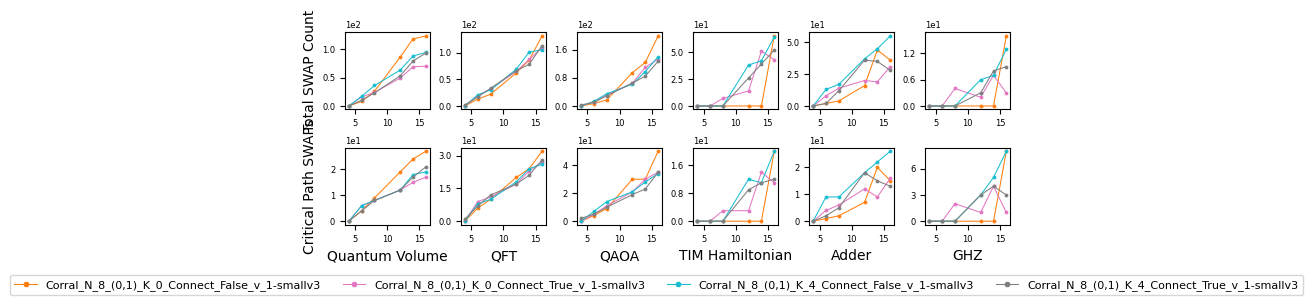

In [12]:
from src.clonk.benchmark_suite.circuit_suite import circuits
from src.clonk.benchmark_suite.main_plotting import benchmark, plot_wrap

#NOTE if run w/ diff params, check main_plotting function to check if different colors will be set

for circuit_gen in circuits.values():
    benchmark(
        backends=simple_backends_v3,
        circuit_generator=circuit_gen,
        q_range=[4, 6, 8, 12, 14, 16],
        continuously_save=1,
        overwrite=0,  # NOTE: turn this to 1 if you want to scrap the saved data and recollect a new batch
        repeat=1,
    )

# NOTE when plotting use motivation = 1 to plot SWAP counts, and motivation = 0 to plot gate durations
plot_wrap(simple_backends_v3, circuits.keys(), motivation=True, plot_average=True)

In [ ]:
#add more qubits testing

from src.clonk.benchmark_suite.circuit_suite import circuits
from src.clonk.benchmark_suite.main_plotting import benchmark, plot_wrap

#NOTE if run w/ diff params, check main_plotting function to check if different colors will be set

for circuit_gen in circuits.values():
    benchmark(
        backends=simple_backends_v3,
        circuit_generator=circuit_gen,
        q_range=[16, 28, 32, 48, 60, 72],
        continuously_save=1,
        overwrite=0,  # NOTE: turn this to 1 if you want to scrap the saved data and recollect a new batch
        repeat=1,
    )

# NOTE when plotting use motivation = 1 to plot SWAP counts, and motivation = 0 to plot gate durations
plot_wrap(simple_backends_v3, circuits.keys(), motivation=True, plot_average=True)

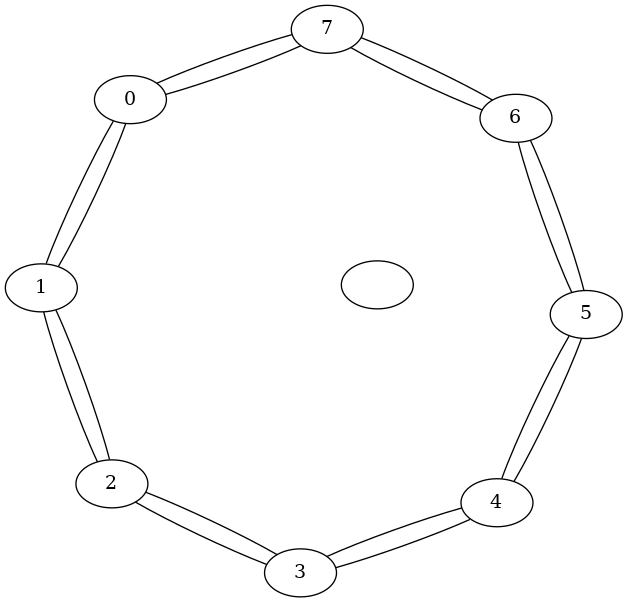

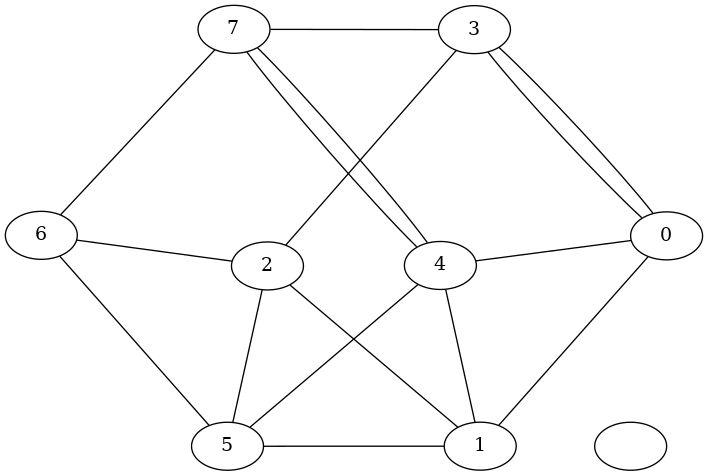

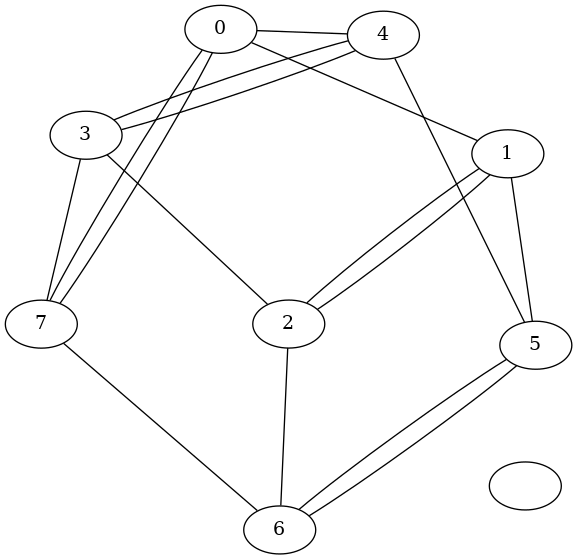

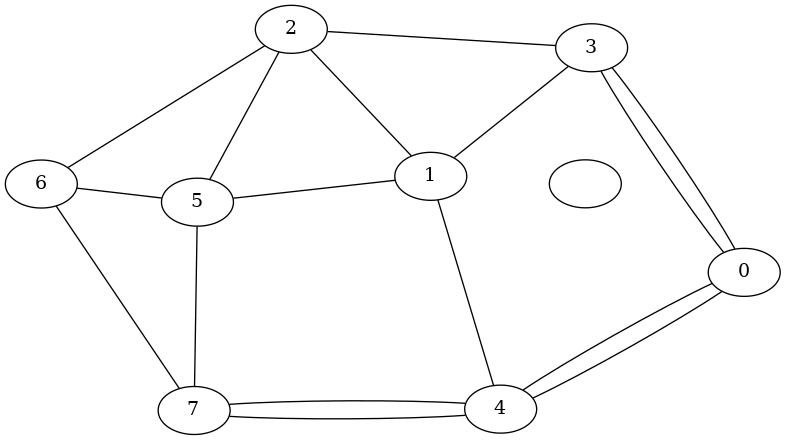

In [17]:
fc = FakeCorral()
n = 8
k = 0

c1 = corral(n//2,2)
c2 = corral(n//2,2)
c = corral(n,2)

c1 = list(fc.add_new_edges(c1, k//2))
c2 = list(fc.add_new_edges(c2, k//2))
c = list(fc.add_new_edges(c, k))

# display(pretty_print(snail_to_connectivity( c )))
display(pretty_print(c ))
combined = connect_corrals_way2(c1,c2)
# display(pretty_print(snail_to_connectivity( combined )))
display(pretty_print( combined ))
n = 8
k = 4

c1 = corral(n//2,2)
c2 = corral(n//2,2)
c = corral(n,2)

c1 = list(fc.add_new_edges(c1, k//2))
c2 = list(fc.add_new_edges(c2, k//2))
c = list(fc.add_new_edges(c, k))

# display(pretty_print(snail_to_connectivity( c )))
display(pretty_print(c ))

combined = connect_corrals_way2(c1,c2)
# display(pretty_print(snail_to_connectivity( combined )))
display(pretty_print( combined ))

In [24]:
fc = FakeCorral()
n = 32
k = 2 

c1 = corral(n//2,2)
c2 = corral(n//2,2)
c = corral(n,2)

c1 = list(fc.add_new_edges(c1, k//2))
c2 = list(fc.add_new_edges(c2, k//2))
c = list(fc.add_new_edges(c, k))

combined = connect_corrals_way2(c1,c2)


display(pretty_print(snail_to_connectivity( c )))
display(pretty_print(snail_to_connectivity( combined )))
print(len(c))
# display(pretty_print(c ))
# display(pretty_print( combined ))

ValueError: list.remove(x): x not in list